# 5. Example: 4DVar Backprop DA using Reservoir Computing ML Model on QGS Model

Using RP model from QGS/Jason Platt's paper: 

In [3]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle
from qgs.params.params import QgParams
from timeit import default_timer as timer
import pandas as pd


In [4]:
random_seed=50
np_rng = np.random.default_rng(seed=random_seed)

## A. Create Nature Run

In [5]:
# Time parameters
dt = 0.5
# transient time to attractor
transient_time = 1.e5
# integration time on the attractor
integration_time = 1.e4


# Setting some model parameters
# Model parameters instantiation with some non-default specs
model_params = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_params.set_atmospheric_channel_fourier_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model_params.ground_params.set_orography(0.2, 1)
model_params.atemperature_params.set_thetas(0.2, 0)

In [6]:
train_size = 100000
valid_size = 10000
transient_size = 1000
test_size = 10000

In [7]:
nature_run = dab.data.QGS(model_params=model_params, store_as_jax=False, delta_t=dt,
                          random_seed=random_seed)
nature_run.generate(n_steps=200*1000, stride=1000, x0=np_rng.random(model_params.ndim)*0.001, mxstep=5000)
x0 = nature_run.values[-1]

In [9]:
nature_run.generate(x0=x0, n_steps=(train_size +  valid_size + transient_size + test_size), mxstep=5000)

In [10]:
nr_train, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    train_size, valid_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


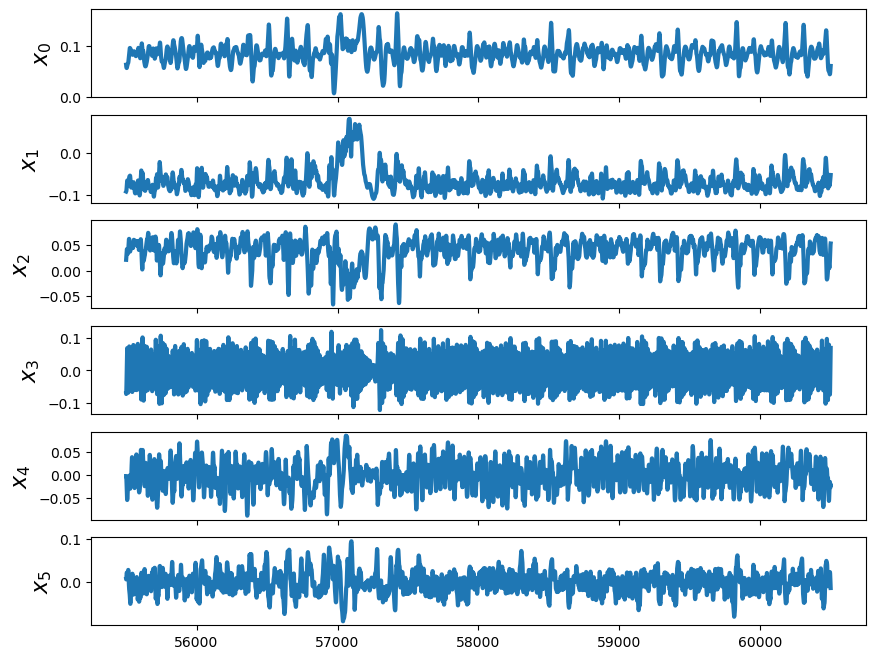

In [8]:
# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:,j], lw = 3, label = 'Nature Run')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
#     ax.set_xlim(54000, 55000)

## B. Generate Observations

In [9]:
# First we need to calculate the per-variable SD for QGS model
obs_sd_scale = 0.1
per_variable_sd = np.std(nr_train.values, axis=0)
obs_sd = 0.1*per_variable_sd

In [10]:

# Now we can define the observer:
obs_qgs_valid = dab.observer.Observer(
    nr_valid, # Data generator object
    time_indices = np.arange(0, nr_valid.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd,  
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

obs_qgs_test = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, nr_test.time_dim, 3), # Observation every 3rd timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd, 
    random_seed=100,
    stationary_observers=True,
    store_as_jax=False
)


# Making observations
obs_vec_valid = obs_qgs_valid.observe()
obs_vec_test = obs_qgs_test.observe()

## C. Define and train model

In [11]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=20, 
    reservoir_dim=2000, 
    input_dim=20, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.98765777241154,
    sigma_bias = 0.675882947305197,
    spectral_radius =  0.376752115791648, # SR 
    leak_rate=0.5343730100231164, # alpha
    log_beta=-20.219432227197363)

In [12]:
# # Train: Takes a few minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)
# forecast_model.save_weights('rc_weights.pkl')

In [13]:
# # Shortcut: load the W_out weights from previous training
weights_path = 'rc_weights.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

In [14]:
# What happens when we run our model without data assimilation?
valid_start = forecast_model.generate(nr_train.values[-1000:])[-1]

valid_run_hidden = [valid_start]
obs_index = 0
for i in range(valid_size-1):
    valid_run_hidden.append(
        forecast_model.update(valid_run_hidden[-1],
                              forecast_model.readout(valid_run_hidden[-1])
                              )
    )
valid_run_system = forecast_model.readout(valid_run_hidden)



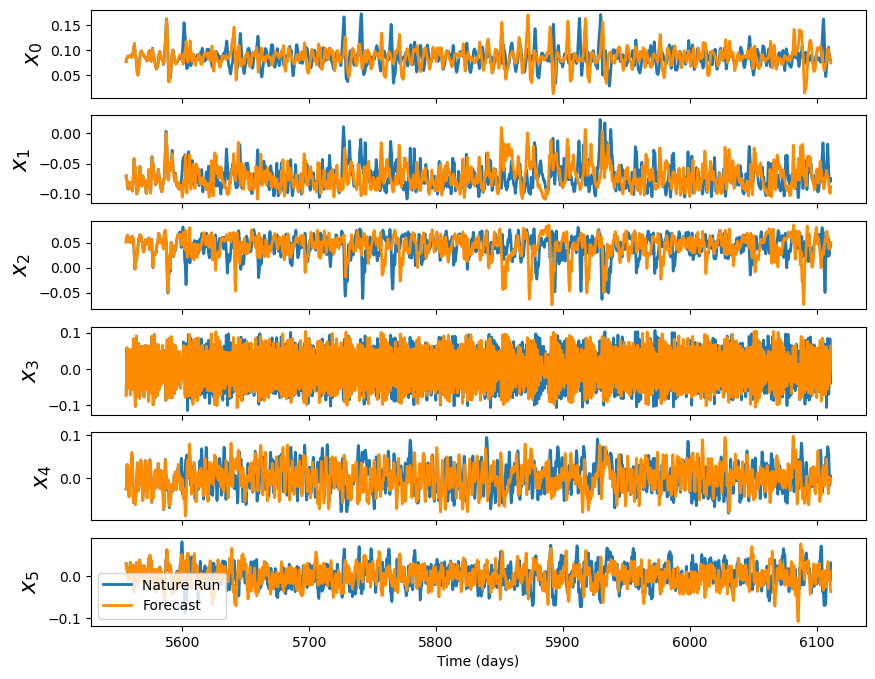

In [15]:

# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_valid.times*160/(60*24), nr_valid.values[:,j], lw = 2, label = 'Nature Run')
    ax.plot(nr_valid.times*160/(60*24), valid_run_system[:,j], lw = 2, label = 'Forecast', color='darkorange')
#     ax.scatter(obs_vec_l96.times, obs_vec_l96.values[:,j],label='Obs', color='green', s=10)
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.legend()
ax.set_xlabel('Time (days)')
plt.show()

## D. Set up and run DA Cycler for validation period

In [16]:
# Load lr and lr_decay from raytune
raytune_results = pd.read_csv('./test_raytune_qgs_v3.csv')
best_row = raytune_results['rmse'].idxmin()
best_lr = raytune_results.loc[best_row, 'config/lr']
best_lr_decay = raytune_results.loc[best_row, 'config/lr_decay']

In [17]:
# Getting standard deviation of reservoir state values for sigma_bg
train_res_values = forecast_model.generate(nr_train.values)
train_res_sd = np.std(train_res_values, axis=0)

In [18]:
obs_total_size = 10*4

# I believe Steve said a better way to do this is to cast the error into the res state rather than calculating sd in res space
sigma_bg = 0.1*train_res_sd #0.005 #0.05*obs_sd


R_valid = (sigma_obs**2)*np.identity(obs_total_size)
B = (sigma_bg**2)*np.identity(forecast_model.reservoir_dim)
S = np.zeros((10, 20))
S[np.arange(S.shape[0]), np.tile(obs_vec_valid.location_indices[0], 1)] = 1
H_valid = S @ forecast_model.Wout.T

In [19]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_train.values[-1000:]
        + np_rng.normal(size = (1000, nr_train.system_dim), scale=obs_sd))[-1], nr_train.values[-1])

In [20]:
def setup_run_v4d_bp(nr, r0, obs_vec, num_epochs, learning_rate, lr_decay,
                     H, B, R):
    
    dc = dab.dacycler.Var4DBackprop(
        system_dim=forecast_model.reservoir_dim,
        delta_t=nr.delta_t,
        H=H,
        B=B,
        R=R,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        num_epochs=num_epochs,
        model_obj=forecast_model,
        obs_window_indices=[0,2,5,8],
        steps_per_window=10, # 10 instead of 9 because inclusive
        loss_growth_limit=100
    )
    cur_tstep = 0

    r0_sv = dab.vector.StateVector(
        values=r0,
        store_as_jax=True)

    out_statevec = dc.cycle(
        input_state = r0_sv,
        start_time = nr.times[cur_tstep],
        obs_vector = obs_vec,
        analysis_window=4.5,
        timesteps=int(nr.time_dim/9)-2,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=2.25)
    
    analyses_stacked = forecast_model.readout(out_statevec.values)
    
    return analyses_stacked

Run the cycler

In [21]:
num_epochs_list = [5, 4, 3, 2, 1] 
output_list = []
times_list = []

for ne in num_epochs_list:
    start = timer()
    cur_output = setup_run_v4d_bp(
        nr=nr_valid, 
        r0 = r0_original,
        obs_vec = obs_vec_valid,
        num_epochs = ne,
        learning_rate = best_lr,
        lr_decay = best_lr_decay,
        H=H_valid,
        B=B,
        R=R_valid)
    times_list.append(timer()-start)
    output_list.append(cur_output)
    print('{} Done, Time = {}'.format(ne, times_list[-1]))


[[30.67816676 30.06133796 29.89572421]
 [31.28212235 29.02666288 28.74616656]
 [28.6942678  24.39576742 23.93852645]
 ...
 [24.95574889 24.62373884 24.49442309]
 [31.84174123 29.88889881 29.66368379]
 [38.03798186 31.78034419 31.16479445]]
5 Done, Time = 158.4776972489999
[[33.52033952 30.67816676 30.06133796]
 [62.68654614 31.31729008 29.04586538]
 [61.37013977 28.8204375  24.43617761]
 ...
 [26.10785369 24.9569841  24.61781177]
 [41.681087   31.80960263 29.91519316]
 [70.27477637 38.23097495 31.8912722 ]]
4 Done, Time = 132.17751297699942
[[44.57683153 33.52033952 30.67816676]
 [45.76499174 63.54150171 31.42059563]
 [42.81890759 63.93026376 29.23055355]
 ...
 [43.32623973 27.25183587 25.09211679]
 [42.85362925 40.20629798 31.65332087]
 [49.6629899  71.71389833 38.7472175 ]]
3 Done, Time = 107.84912397200242
[[44.57683153 33.52033952]
 [47.77797683 69.03628006]
 [46.75527681 81.32302306]
 ...
 [62.35642978 97.96489943]
 [46.20159637 40.69401873]
 [52.69967715 45.92591761]]
2 Done, Tim

In [22]:
results_dict = {
    'num_epochs': num_epochs_list,
    'time': times_list
}

In [23]:
results_dict['rmse'] = [np.sqrt(np.mean(np.square(nr_valid.values[:-19] - out))) for out in output_list]

In [24]:
time_rmse_df = pd.DataFrame(results_dict)

In [25]:
time_rmse_df.to_csv('./out/qgs_bp_v10_raytune_results.csv')

In [26]:
# time_rmse_df.to_csv('./out/qgs_bp_v7_1e-6_decay09everystep_sgd.csv')
time_rmse_df = pd.read_csv('./out/qgs_bp_v10_raytune_results.csv')

# Figure: num epochs vs. time vs rmse

In [27]:
time_rmse_df

,Unnamed: 0,num_epochs,time,rmse
0,0,5,158.477697,0.004033
1,1,4,132.177513,0.004034
2,2,3,107.849124,0.004035
3,3,2,81.981368,0.004158
4,4,1,55.909431,0.504198


In [28]:
time_rmse_df['time_per_cycle'] = time_rmse_df['time']/(int(valid_size/9)-2)

<AxesSubplot: xlabel='num_epochs'>

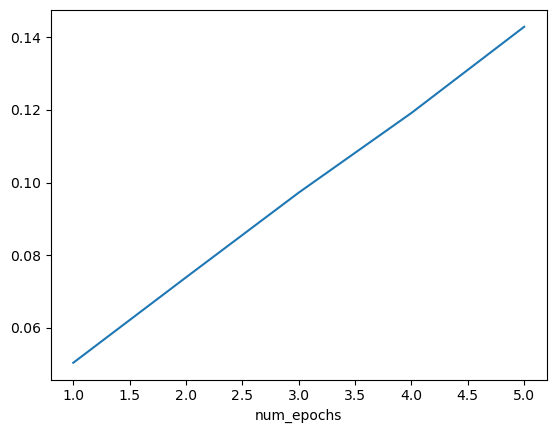

In [29]:
time_rmse_df.set_index('num_epochs')['time_per_cycle'].plot()

<AxesSubplot: xlabel='num_epochs'>

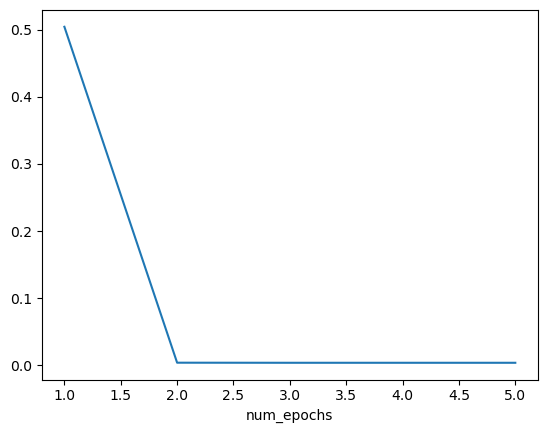

In [30]:
time_rmse_df.set_index('num_epochs')['rmse'].plot()

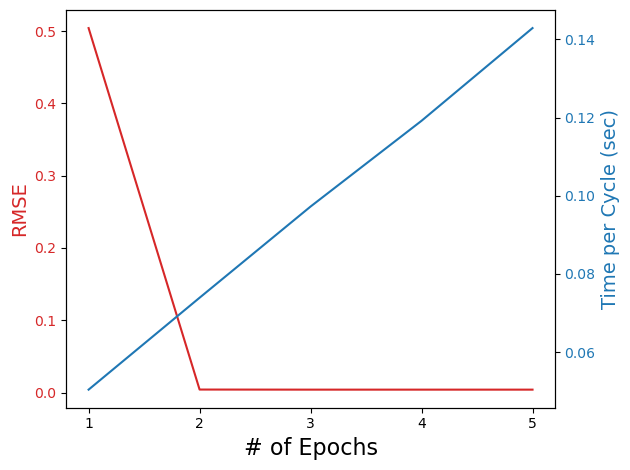

In [31]:
# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('# of Epochs', size=16)
ax1.set_ylabel('RMSE', color=color, size=14)
ax1.plot(time_rmse_df['num_epochs'], time_rmse_df['rmse'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(np.arange(1, 6))

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Time per Cycle (sec)', color=color, size=14)
ax2.plot(time_rmse_df['num_epochs'], time_rmse_df['time_per_cycle'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [32]:
analyses_stacked = output_list[2]

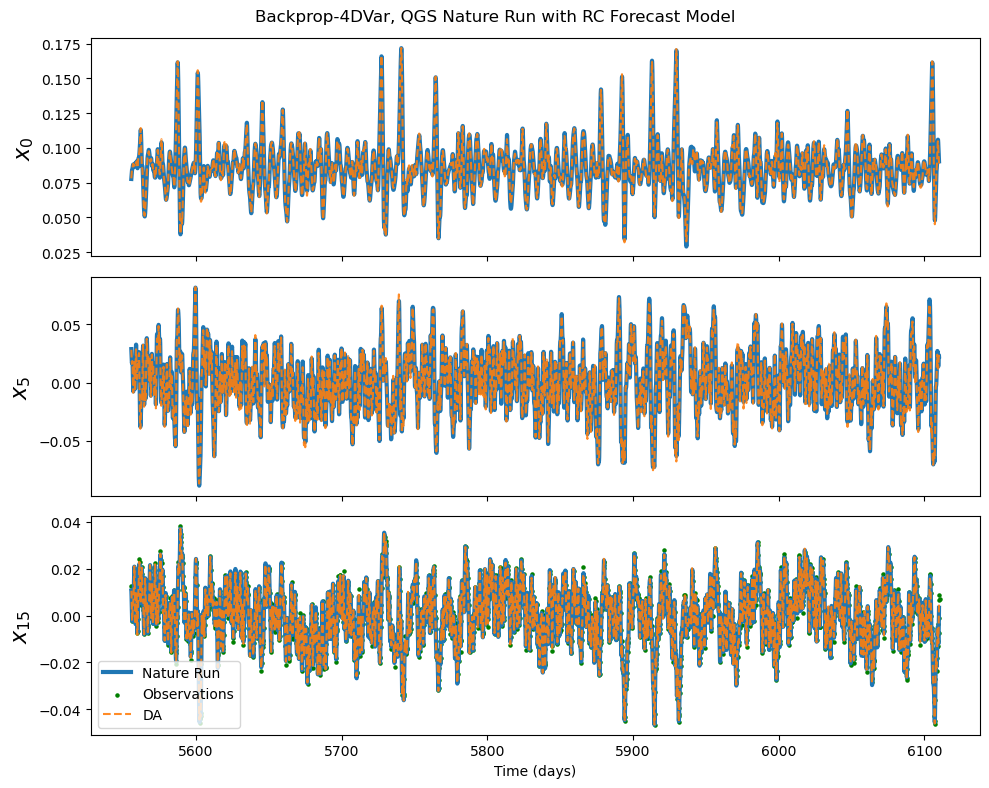

In [33]:
# Plot them all
fig, axes = plt.subplots(3, 1, sharex = True, figsize = (10, 8))
fig.suptitle('Backprop-4DVar, QGS Nature Run with RC Forecast Model')
vars_to_plot = [0, 5, 15]
for i, ax in enumerate(axes):
    j = vars_to_plot[i]
    ax.plot(nr_valid.times[:-19]*160/(60*24), nr_valid.values[:-19, j], label='Nature Run', lw=3)
    if j in obs_vec_valid.location_indices[0]:
        ax.scatter(obs_vec_valid.times[:-4]*160/(60*24),
                   obs_vec_valid.values[:-4, np.where(j == obs_vec_valid.location_indices[0])[0]],
                   label='Observations',color='green', s=5)
    ax.plot(nr_valid.times[:analyses_stacked.shape[0]]*160/(60*24), analyses_stacked[:, j],
            label='DA', ls='--', lw=1.5, alpha=0.9)
    ax.set_ylabel(r'$x_{' +str(j) + '}$', fontsize = 16)
    if i == 2:
        ax.legend()
ax.set_xlabel('Time (days)')

# ax.set_xlim(10090, 12110)
fig.tight_layout()
plt.show()

In [34]:
np.sqrt(np.mean(np.square(nr_valid.values[:-19] - analyses_stacked)))

0.004034824811167031

# E. Run for test period

In [35]:
r0_original_test = forecast_model.update(forecast_model.generate(
        nr_transient.values
        +  np_rng.normal(size = (nr_transient.time_dim, nr_transient.system_dim), scale=obs_sd))[-1], nr_transient.values[-1])

In [36]:
obs_total_size = 10*4
sigma_obs=np.tile(obs_sd[obs_vec_test.location_indices[0]], 4)*1.25 # Used 0.005 normally, 0.01 increased error
sigma_bg = 0.1*train_res_sd #0.005 #0.05*obs_sd

R_test = (sigma_obs**2)*np.identity(obs_total_size)
B = (sigma_bg**2)*np.identity(forecast_model.reservoir_dim)
S = np.zeros((10, 20))
S[np.arange(S.shape[0]), np.tile(obs_vec_test.location_indices[0], 1)] = 1
H_test = S @ forecast_model.Wout.T

In [37]:
num_epochs = 3

start = timer()

cur_output = setup_run_v4d_bp(
    nr=nr_test, 
    r0 = r0_original_test,
    obs_vec = obs_vec_test,
    num_epochs = num_epochs,
    learning_rate = best_lr,
    lr_decay = best_lr_decay,
    H=H_test,
    B=B,
    R=R_test)

print(timer()-start)



[[44.81641076 27.83891759 25.98631608]
 [76.98742061 46.56309393 30.9689215 ]
 [32.50423965 33.75856851 29.57525674]
 ...
 [46.15669419 39.48567189 35.62266996]
 [29.53829029 35.05550229 25.77445245]
 [32.13327255 30.55917043 23.92598835]]
107.2495711019983


In [46]:
B

array([[1.22659303e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.01880502e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.62938184e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.68262431e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.77000453e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.46295822e-05]])

In [38]:
np.sqrt(np.mean(np.square(nr_test.values[:-19] - cur_output)))

0.004200932674443319

In [39]:
analyses_stacked = cur_output

In [40]:
nr_test.times[:-19]*160/(60*24)

array([6166.66666667, 6166.72222222, 6166.77777778, ..., 6721.        ,
       6721.05555556, 6721.11111111])

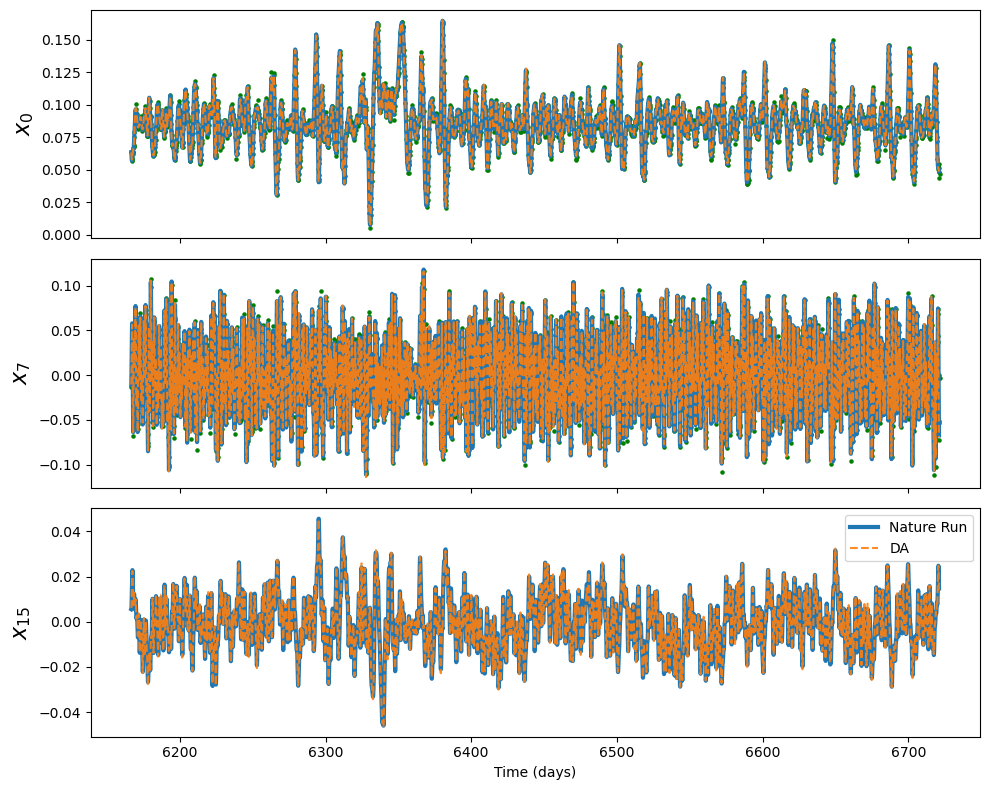

In [84]:
# Plot them all
fig, axes = plt.subplots(3, 1, sharex = True, figsize = (10, 8))
# fig.suptitle('Backprop-4DVar, QGS Nature Run with RC Forecast Model')
vars_to_plot = [0, 7, 15]
for i, ax in enumerate(axes):
    j = vars_to_plot[i]
    ax.plot(nr_test.times[:-19]*160/(60*24), nr_test.values[:-19, j], label='Nature Run', lw=3)
    if j in obs_vec_test.location_indices[0]:
        ax.scatter(obs_vec_test.times[:-4]*160/(60*24),
                   obs_vec_test.values[:-4, np.where(j == obs_vec_test.location_indices[0])[0]],
                   label='Observations',color='green', s=5)
    ax.plot(nr_test.times[:analyses_stacked.shape[0]]*160/(60*24), analyses_stacked[:, j],
            label='DA', ls='--', lw=1.5, alpha=0.9)
    ax.set_ylabel(r'$x_{' +str(j) + '}$', fontsize = 16)
    if i == 2:
        ax.legend()
ax.set_xlabel('Time (days)')

# ax.set_xlim(10090, 12110)
fig.tight_layout()
plt.show()

In [51]:
per_variable_sd

array([0.01727701, 0.01915924, 0.02057968, 0.04913286, 0.03088652,
       0.02476253, 0.03993278, 0.04138972, 0.06736186, 0.06738497,
       0.00755943, 0.01015377, 0.01306355, 0.01574743, 0.0170037 ,
       0.01162624, 0.01494333, 0.0155819 , 0.02319274, 0.02301102])

In [79]:
i = 0
obs_rmses = []
da_rmses = []
for li in obs_vec_test.location_indices[0]:
    print(li)
    print('Obs rmse: {}'.format(np.sqrt(np.mean(np.square(obs_vec_test.errors[:, i])))))
    obs_rmses.append(np.sqrt(np.mean(np.square(obs_vec_test.errors[:, i]))))
    i+=1
    print('DA RMSE: {}'.format(np.sqrt(np.mean(np.square(nr_test.values[:-19, li] - cur_output[:, li])))))
    da_rmses.append(np.sqrt(np.mean(np.square(nr_test.values[:-19, li] - cur_output[:, li]))))

8
Obs rmse: 0.006797501364062804
DA RMSE: 0.005740582084143438
10
Obs rmse: 0.0007507364038547328
DA RMSE: 0.0008144466857511865
1
Obs rmse: 0.0018613283962670589
DA RMSE: 0.0017625553594464453
13
Obs rmse: 0.0015749873060223287
DA RMSE: 0.002020204676720179
14
Obs rmse: 0.0016839559186896805
DA RMSE: 0.001893720981042114
4
Obs rmse: 0.0031013939156049213
DA RMSE: 0.003291852885866296
7
Obs rmse: 0.004117017088828383
DA RMSE: 0.008079673443289139
0
Obs rmse: 0.00173321318588
DA RMSE: 0.001372406355740464
11
Obs rmse: 0.0010187028945150328
DA RMSE: 0.0011306321216945575
19
Obs rmse: 0.002350754274696972
DA RMSE: 0.0021815378191096194


In [78]:
np.array(obs_rmses) - np.array(da_rmses)

array([ 1.05691928e-03, -6.37102819e-05,  9.87730368e-05, -4.45217371e-04,
       -2.09765062e-04, -1.90458970e-04, -3.96265635e-03,  3.60806830e-04,
       -1.11929227e-04,  1.69216456e-04])

In [75]:
np.mean(da_rmses)

0.002828761241280344

In [74]:
np.mean(obs_rmses)

0.0024989590748421913

In [62]:
obs_vec_test.location_indices

array([[ 8, 10,  1, ...,  0, 11, 19],
       [ 8, 10,  1, ...,  0, 11, 19],
       [ 8, 10,  1, ...,  0, 11, 19],
       ...,
       [ 8, 10,  1, ...,  0, 11, 19],
       [ 8, 10,  1, ...,  0, 11, 19],
       [ 8, 10,  1, ...,  0, 11, 19]])

In [65]:
np.sqrt(np.mean(np.square(nr_test.values[:-19, 10] - cur_output[:, 10])))

0.0008144466857511865

In [66]:
np.sqrt(np.mean(np.square(obs_vec_test.errors[:, 1])))

0.0007507364038547328

In [55]:
obs_vec_test.location_indices[0, -3]

0

In [42]:
np.sqrt(np.mean(np.square(obs_vec_test.errors)))

0.0030279823152710755

In [44]:
nr_test_vals_obslocs = nr_test.values[:, obs_vec_test.location_indices]
cur_output_obslocs = cur_output[:, obs_vec_test.location_indices]

In [45]:
np.sqrt(np.mean(np.square(nr_test_vals_obslocs[:-19] - cur_output_obslocs)))

0.003583712703080183